In [ ]:
########################################################################
## Pattern Recognition - Practice 3 (Problem 2)
## Chung-Ang University
## Lecturer: Jongwon Choi (The graduate school of advanced imaging science, multimedia & film)
##           email: choijw@cau.ac.kr
########################################################################

# DO NOT USE ANY ADDITIONAL LIBRARY
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

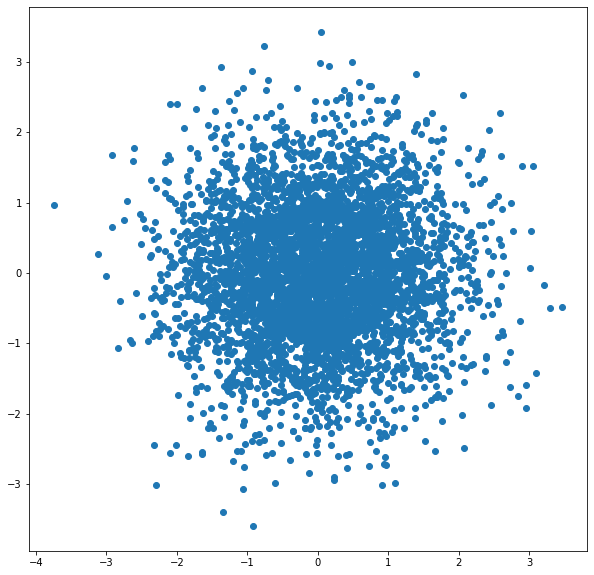

In [ ]:
###################
##   NOISY DATA  ##
###################
SIZE_SAMPLE = 5000
SIZE_INLIER1 = 500
SIZE_INLIER2 = 500
np.random.seed(0)
feature_inlier1 = 0.5*np.random.randn(SIZE_INLIER1, 2)
feature_inlier1[:, 1] = 1.2327*feature_inlier1[:, 0] + 0.1*np.random.randn(SIZE_INLIER1)
feature_inlier2 = np.random.uniform(-1, 1, (SIZE_INLIER2, 2))
feature_inlier2[:, 1] = (2*(np.random.randn(SIZE_INLIER2)>0)-1)*np.sqrt(np.abs((0.837 + 0.1*np.random.randn(SIZE_INLIER2)) - feature_inlier2[:, 0]**2))
feature_outlier = np.random.randn(SIZE_SAMPLE-SIZE_INLIER1-SIZE_INLIER2, 2)
feature = np.random.permutation(np.concatenate( (feature_inlier1, feature_inlier2, feature_outlier), 0 ))

# Plot the samples
f, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(feature[:, 0], feature[:, 1])
f.show()

In [ ]:
#############################################################
## Problem 1 - A
linear_model = np.zeros(3) # [a, b, c] in a linear model of "ax + by + c = 0"
inlier_flag = np.zeros(SIZE_SAMPLE) # 0 if a sample is outlier, 1 otherwise.

In [ ]:
def dist(linear_model, point): # distance between a line and a point
  distance = 0
  a, b, c = linear_model[0], linear_model[1], linear_model[2] # ax+by+c=0
  x, y = point[0], point[1] # x, y
  distance = np.abs(a*x + b*y + c) / np.sqrt(a**2+ b**2) # 점과 직선 사이의 거리
  return distance

In [ ]:
############################################################
## Your implementation (RANSAC line fitting)

b = -np.ones((2, 1), dtype=np.float32)
one = np.ones((1,), dtype=np.float32)
def line_eq(A:np.ndarray):
  # 두 점을 지나는 직선의 방정식 찾기
  # ax+by+c=0 에서 c=1로 고정
  # np.linalg.solve 로 연립방정식 풀기
  return np.concatenate((np.reshape(np.linalg.solve(A, b), (-1, )), one))

# trial_iters: RANSAC 시행 횟수
# eps: inlier 기준 (거리)
trial_iters, eps = 2000, 0.25

N, d = feature.shape
best_num_inliers = 0
for _ in range(trial_iters):
  # 임의의 두 점을 잇는 직선
  trial_model = line_eq(feature[np.random.choice(N, 2, replace=False)])

  # inlier 검사
  trial_flag = np.zeros_like(inlier_flag)
  for n in range(N):
    d = dist(trial_model, feature[n])
    if d < eps:
      trial_flag[n] = 1

  # 가장 많은 inlier를 가지는 모델 저장
  num_inliers = np.sum(trial_flag)
  if best_num_inliers < num_inliers:
    best_num_inliers = num_inliers
    linear_model = trial_model
    inlier_flag = trial_flag

# inlier 따로 모으기
inlier_features = []
for i_idx in range(inlier_flag.shape[0]):
  if inlier_flag[i_idx] != 0:
    inlier_features.append(feature[i_idx])

inlier_features = np.stack(inlier_features, axis=0)
b = -np.ones((inlier_features.shape[0], 1), dtype=np.float32) # ax + by = -c, c=1로 고정했으므로 ax+by=-1

# normal equation으로 inlier re-fitting
y = np.linalg.inv(inlier_features.T @ inlier_features) @ inlier_features.T @ b
linear_model = np.array([y[0].item(), y[1].item(), 1])

############################################################

print(f'best_inlier num: {np.sum(inlier_flag)}')
print(f'best_model: {linear_model}') 

best_inlier num: 1424.0
best_model: [-2.45974824  1.91630551  1.        ]


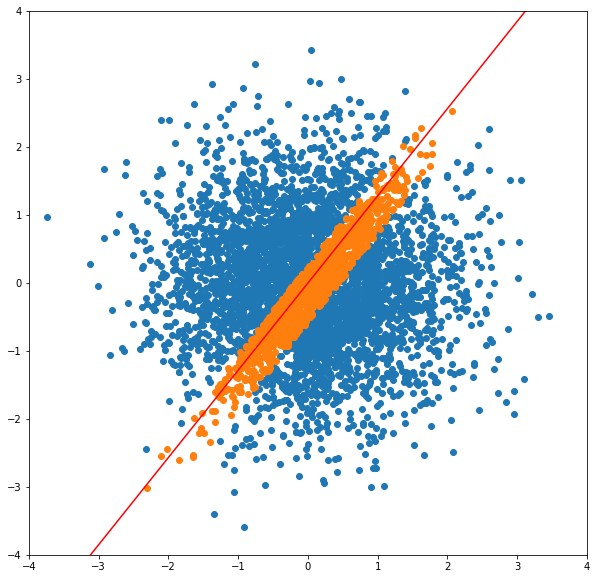

In [ ]:
############################################################
# Plot the samples
f, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(feature[inlier_flag==0, 0], feature[inlier_flag==0, 1]) #outlier scatter
ax.scatter(feature[inlier_flag==1, 0], feature[inlier_flag==1, 1]) #inlier scatter
x_range = np.arange(-4,4,0.01)
ax.plot(x_range, -1*linear_model[0]/linear_model[1]*x_range, 'r') #linear model output
plt.xlim(-4, 4)
plt.ylim(-4, 4)
f.show()

In [ ]:
#############################################################
## Problem 1 - B : Fill in the following 2 variables according to the results of your program!
circle_model = np.zeros(3) # [cx, cy, r] : (cx, cy) is center point, r is radius
inlier_flag = np.zeros(SIZE_SAMPLE) # 0 if a sample is outlier, 1 otherwise.

In [ ]:
def dist_circle(circle_model, point):
  distance = 0

  cx, cy, r = circle_model[0], circle_model[1], circle_model[2]
  x, y = point[0], point[1]

  distance = np.sqrt((cx-x)**2 + (cy-y)**2) # 원의 중심과 점사이의 거리

  return distance

In [ ]:
############################################################
## Your implementation

trial_iters, eps = 2000, 0.25

b = -np.ones((2, 1), dtype=np.float32)
one = np.ones((1,), dtype=np.float32)
def line_eq(A:np.ndarray):
  # 두 점을 지나는 직선의 방정식 찾기
  # ax+by+c=0 에서 c=1로 고정
  return np.concatenate((np.reshape(np.linalg.solve(A, b), (-1, )), one))

def orthogonal_line(line_model:np.ndarray, point:np.ndarray):
  # line_model에 직교하면서서 point를 지나는 직선
  a, b = line_model[0].item(), line_model[1].item()
  x, y = point[0].item(), point[1].item()
  k = a * y - b * x

  return np.array([b / k, -a / k, 1]) # ax+by+c=0 에서 c=1로 고정

def line_intersection(line_model1:np.ndarray, line_model2:np.ndarray):
  # c=1로로 고정된된 두 직선의의 교점
  a1, b1 = line_model1[0].item(), line_model1[1].item()
  a2, b2 = line_model2[0].item(), line_model2[1].item()
  
  # https://zetawiki.com/wiki/두_직선의_교차점
  x = (b1-b2)/(a1*b2-a2*b1)
  y = -a1/b1 * x - 1/b1

  return np.array([x, y])

def fit_circle(A):
  # A: (3, 2) , 3 points of 2 features (x, y)
  # 세 점을 지나는 외접원의 중심과 반지름 구하기

  line12 = line_eq(A[:2]) # 0, 1 두 점을 지나는 직선
  line23 = line_eq(A[1:]) # 1, 2 두 점을 지나는 직선 

  cent12 = np.mean(A[:2], axis=0) # 0, 1 두 점의 1:1 내분점
  cent23 = np.mean(A[1:], axis=0) # 1, 2 두 점의 1:1 내분점

  orth12 = orthogonal_line(line12, cent12) # line12에 직교하면서 cent12를 지나는 직선
  orth23 = orthogonal_line(line23, cent23) # line12에 직교하면서 cent12를 지나는 직선

  center = line_intersection(orth12, orth23) # orth12, orth23 두 직선의 교점
  radius = np.sqrt((A[0, 0] - center[0]) ** 2 + (A[0, 1] - center[1]) ** 2) # 반지름

  return np.array([center[0].item(), center[1].item(), radius.item()]) # [cx, cy, r]

best_num_inliers = 0
N, d = feature.shape

for _ in range(trial_iters):
  # 임의의 점 3개 선택
  trial_model = fit_circle(feature[np.random.choice(N, 3, replace=False)])

  # inlier 검사
  trial_flag = np.zeros_like(inlier_flag)
  for n in range(N):
    d = dist_circle(trial_model, feature[n])
    if abs(d - trial_model[2]) < eps:
      trial_flag[n] = 1

  # 가장 많은 inlier를 가지는 모델 저장
  num_inliers = np.sum(trial_flag)
  if best_num_inliers < num_inliers:
    best_num_inliers = num_inliers
    circle_model = trial_model
    inlier_flag = trial_flag

inlier_features = []
for i_idx in range(inlier_flag.shape[0]):
  if inlier_flag[i_idx] != 0:
    inlier_features.append(feature[i_idx])
inlier_features = np.stack(inlier_features, axis=0)

# inlier들을 통해 원 re-fitting
# https://t1.daumcdn.net/cfile/blog/1845BA524E389F8724?download
A = np.concatenate((inlier_features, np.ones((inlier_features.shape[0],1))), axis=1)
A2 = A**2
B = -A2[:, 0] - A2[:, 1]

x = np.linalg.inv(A.T @ A) @ A.T @ B
a = -x[0] / 2.0
b = -x[1] / 2.0
r = np.sqrt(a**2 + b**2 - x[2])
circle_model = np.array([a.item(), b.item(), r.item()])
############################################################

print(f'best_inlier num: {np.sum(inlier_flag)}')
print(f'best_model: {circle_model}') 

best_inlier num: 1822.0
best_model: [0.0191599  0.00572593 0.88866271]


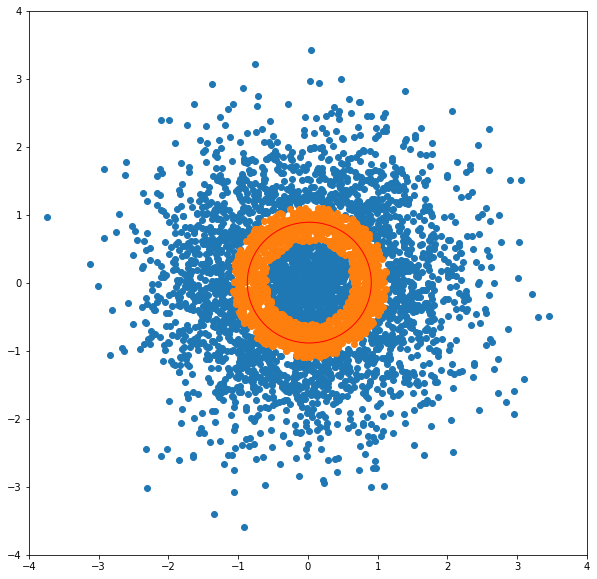

In [ ]:
##########################################################
# Plot the samples
f, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(feature[inlier_flag==0, 0], feature[inlier_flag==0, 1]) #outlier scatter
ax.scatter(feature[inlier_flag==1, 0], feature[inlier_flag==1, 1]) #inlier scatter
circle1 = plt.Circle((circle_model[0], circle_model[1]), circle_model[2], color='r', fill=False) #circle model output
ax.add_artist(circle1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
f.show()